In [1]:
import sys 
sys.path.append("../")

from mps_utils import * 
import matplotlib.pyplot as plt 
import warnings
import matplotlib.colors as plt_colors
from matplotlib.ticker import LogLocator
import matplotlib.collections as mcoll
import numpy as np
from matplotlib.legend_handler import HandlerLineCollection
import matplotlib.gridspec as gridspec


np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
sigma = 0.1 
mu = 0.5
f = lambda x: 2/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (1 - ((x-mu)/sigma)**2 ) * np.exp(- (x-mu)**2/(2*sigma**2))

df = lambda x: -4/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (x-mu)/(sigma**2) * np.exp(- (x-mu)**2/(2*sigma**2)) - (x-mu)/(sigma**2) * f(x)

In [3]:
### segmentation of [0,1]
m = 5
l = 2**m
x_coarse = np.linspace(0,1,l+1)
poly_list = get_polys(x_coarse,f,df)  

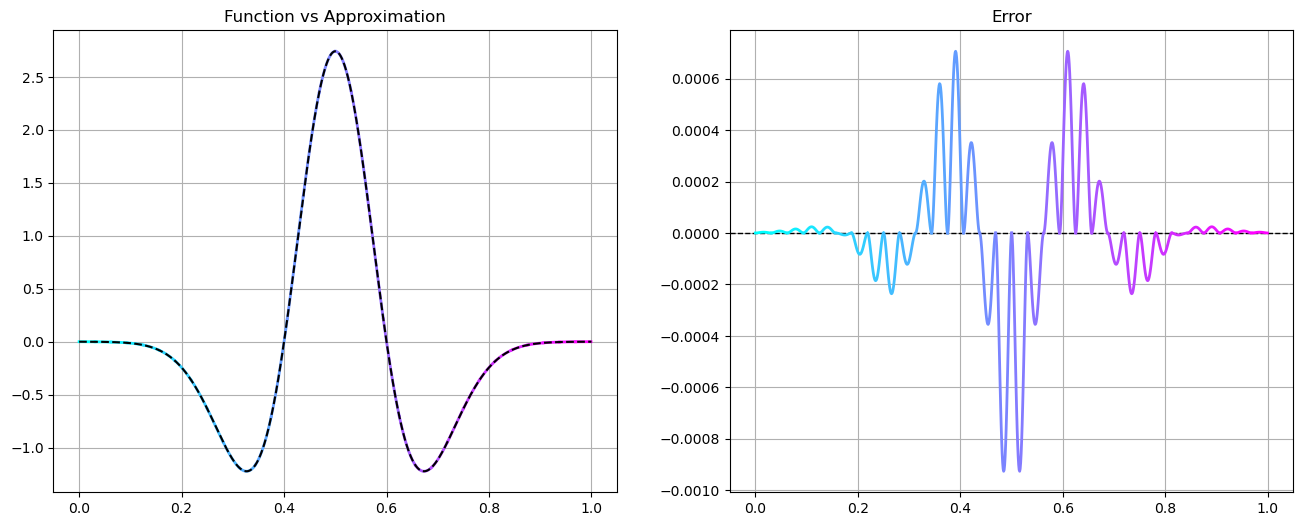

In [4]:
n = 10
N = 2**n
x = np.linspace(0, 1 - 1/N, N)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
colors = plt.cm.cool(np.linspace(0, 1, l))  # l shades for curves

# Plot zero line in error plot
ax[1].axhline(0, color="black", linestyle="--", linewidth=1.0)

# Piecewise cubic approximants
for idx, v in enumerate(poly_list):
    xi = x[idx * N // l : (idx + 1) * N // l + 1]
    ax[0].plot(xi, apply(v, xi), color=colors[idx], linewidth=2)
    ax[1].plot(xi, apply(v, xi) - f(xi), color=colors[idx], linewidth=2)

# Plot true function (smooth, dashed black line)
x_fine = np.linspace(0, 1, 2000)
ax[0].plot(x_fine, f(x_fine), 'k--', linewidth=1.5, label="True f(x)")

# Titles, grids, legend
ax[0].set_title('Function vs Approximation')
ax[1].set_title('Error')
ax[0].grid(True)
ax[1].grid(True)


In [5]:
def fidelity(m, n):
    l = 2**m
    x_coarse = np.linspace(0,1,l+1)
    poly_list = get_polys(x_coarse,f,df)  
    
    N = 2**n
    x = np.linspace(0, 1 - 1/N, N)
    
    approx  = []
    for idx, v in enumerate(poly_list):
        xi = x[idx * N // l : (idx + 1) * N // l ]
        approx.append(apply(v, xi))
    
    approx_vec = np.hstack(approx)
    true_vec = f(x)
    
    return 1 - np.dot(approx_vec, true_vec)**2/(np.dot(true_vec, true_vec)**2)

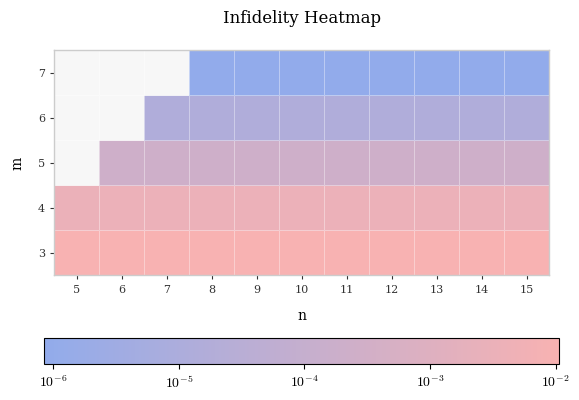

In [6]:
plt.rcParams.update({
    "mathtext.fontset": "cm",    # Computer Modern
    "font.family": "serif"
})

# Define the ranges
m_values = [3, 4, 5, 6, 7]
n_values = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# Build matrix of fidelities
data = np.zeros((len(m_values), len(n_values)))
for i, m in enumerate(m_values):
    for j, n in enumerate(n_values):
        if m < n:
            data[i, j] = fidelity(m, n)
        else:
            data[i, j] = np.nan   # mask invalid entries

# Create meshgrid for cell edges
x_edges = np.arange(min(n_values)-0.5, max(n_values)+1-0.5+1)
y_edges = np.arange(min(m_values)-0.5, max(m_values)+1-0.5+1)

# Set up the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Custom colormap
pastel_colors = [
    (0.15, 0.35, 0.85),   # pastel blue
    (0.95, 0.40, 0.40),   # pastel red/pink
]

cmap = plt_colors.LinearSegmentedColormap.from_list("tikz_pastel", pastel_colors, N=256)
cmap.set_bad(color="#f0f0f0")

# Plot with log normalization
im = ax.pcolormesh(
    x_edges, y_edges, data,
    cmap=cmap,
    norm=plt_colors.LogNorm(vmin=np.nanmin(data[data > 0]), vmax=np.nanmax(data)),
    edgecolors="white", linewidth=0.5, alpha=0.5
)

# Axis formatting
ax.set_xticks(n_values)
ax.set_yticks(m_values)
ax.set_xlabel("n", fontsize=10, labelpad=10)
ax.set_ylabel("m", fontsize=10, labelpad=10)
ax.set_aspect('equal')

# Smaller ticks everywhere
ax.tick_params(axis='both', which='major', labelsize=8, length=3, width=0.8, colors='#333333')

# Add subtle border
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')
    spine.set_linewidth(1)

# Colorbar
cbar = fig.colorbar(
    im, ax=ax, orientation="horizontal",
    pad=0.2, fraction=0.085
)

# Set colorbar ticks to powers of 10
data_min = np.nanmin(data[data > 0])
data_max = np.nanmax(data)

# Find the range of powers of 10 that span our data
min_power = int(np.floor(np.log10(data_min)))
max_power = int(np.ceil(np.log10(data_max)))

# Generate powers of 10 within our data range
powers_of_10 = []
for power in range(min_power, max_power + 1):
    tick_value = 10**power
    if data_min <= tick_value <= data_max:
        powers_of_10.append(tick_value)

# Set the ticks and labels
cbar.set_ticks(powers_of_10)
cbar.set_ticklabels([f'$10^{{{int(np.log10(tick))}}}$' for tick in powers_of_10])
# Remove minor ticks from colorbar
cbar.ax.tick_params(which='minor', size=0)  # Hide minor tick lines
cbar.ax.minorticks_off()  # Turn off minor ticks completely



# Title
ax.set_title("Infidelity Heatmap", fontsize=12, pad=20)

plt.tight_layout()
plt.savefig("../Finalized Figures/mnplot.pdf", dpi=300)
plt.show()

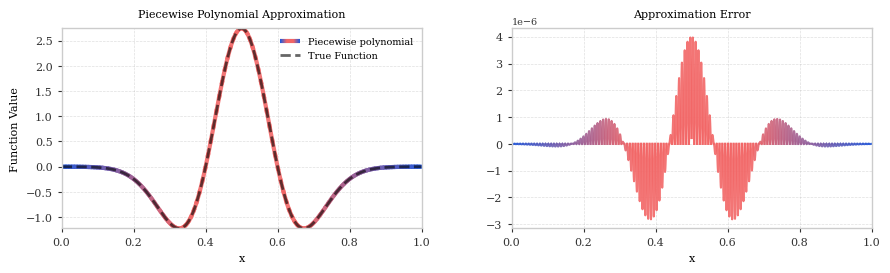

In [7]:
# --- Custom legend handler for gradient line ---
class HandlerGradientLine(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create a gradient line for the legend
        x_legend = np.linspace(xdescent, xdescent + width, 100)
        y_legend = np.full_like(x_legend, ydescent + height/2)
        
        points = np.array([x_legend, y_legend]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = mcoll.LineCollection(
            segments, 
            cmap=orig_handle.cmap,
            linewidth=3,
            transform=trans
        )
        lc.set_array(np.linspace(0, 1, len(x_legend)-1))
        return [lc]

def gradient_legend_line(cmap):
    """Dummy object for gradient legend entry."""
    line = mcoll.LineCollection([], cmap=cmap)
    return line

# --- Your plotting code ---
n, m = 10, 6
l = 2**m

f_shift_scale  = lambda x : f(x/2 + 1/(2 * N))
df_shift_scale = lambda x : 1/2 * df(x/2 + 1/(2 * N))

x_coarse = np.linspace(0,1,l+1)
poly_list = get_polys(x_coarse, f_shift_scale, df_shift_scale)  

N = 2**n
x = np.linspace(0, 1 - 1/N, N) 
x_shift = np.linspace(0, 1 - 1/N, N) + 1/(2* N) 

# Reduced figure size and adjusted spacing
fig, ax = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True)

# Define custom pastel colormap
pastel_colors = [
    (0.15, 0.35, 0.85),   # pastel blue
    (0.95, 0.40, 0.40),   # pastel red/pink
]
cmap = plt_colors.LinearSegmentedColormap.from_list("tikz_pastel", pastel_colors+pastel_colors[::-1], N=2*l)
colors = [cmap(i) for i in np.linspace(0, 1, 2*l)] 

#Plot piecewise polynomials and their errors
for idx, v in enumerate(poly_list):
    xi = x[idx * (N) // l : (idx + 1) * (N) // l + 1]
    yi = apply(v, (xi))
    ax[0].plot(1/2*xi+1/(2*N), yi, color=colors[idx], linewidth=3, alpha=0.9)
    ax[1].plot(1/2*xi+1/(2*N), f(1/2*xi+1/(2*N)) - yi, color=colors[idx], linewidth=1.5, alpha=0.9)
    
    ax[0].plot(1 - (1/2*xi+1/(2*N)), yi, color=colors[idx], linewidth=3, alpha=0.9)
    ax[1].plot(1 - (1/2*xi+1/(2*N)), f(1 - (1/2*xi+1/(2*N))) - yi, color=colors[idx], linewidth=1.5, alpha=0.9)

#Reference function (placeholder)
ref_line, = ax[0].plot(x_shift, f(x_shift), '--', color='k', alpha=0.6, linewidth=2, label="True Function")

# --- Legend with gradient line ---
gradient_handle = gradient_legend_line(cmap)
ax[0].legend(
    [gradient_handle, ref_line],  # Remove ref_line for now since it's commented out
    ["Piecewise polynomial", "True Function"],
    loc="best", fontsize=7, frameon=False,
    handler_map={mcoll.LineCollection: HandlerGradientLine()},
)

# Titles with reduced padding
ax[0].set_title("Piecewise Polynomial Approximation", fontsize=8, pad=8)
ax[1].set_title("Approximation Error", fontsize=8, pad=8)

# Axis labels with reduced padding
ax[0].set_ylabel("Function Value", fontsize=8, labelpad=4)
ax[0].set_xlabel("x", fontsize=8, labelpad=4)
ax[1].set_xlabel("x", fontsize=8, labelpad=4)

# Set axis limits to reduce whitespace
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)
ax[0].set_ylim(f(x).min(), f(x).max())  # Uncomment when you have your data

# Grid and borders
for axi in ax:
    axi.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
    axi.tick_params(axis='both', which='major', labelsize=8, length=3, width=0.8, colors='#333333')
    for spine in axi.spines.values():
        spine.set_edgecolor('#cccccc')
        spine.set_linewidth(1)

ax[1].yaxis.offsetText.set_fontsize(7)
# Use subplots_adjust for more precise control over spacing
plt.subplots_adjust(
    left=0.08,      # Reduce left margin
    bottom=0.12,    # Reduce bottom margin  
    right=0.98,     # Reduce right margin
    top=0.92,       # Reduce top margin
    wspace=0.25,    # Reduce space between subplots
    hspace=0.2      # Vertical spacing (not needed for 1 row, but good to set)
)

plt.savefig("../Finalized Figures/polynomial_approx.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()


In [8]:
n = 10
N = 2**n
x = np.linspace(0, 1 - 1/N, N) + 1/(2*N)
true_state = f(x) / np.linalg.norm(f(x))
f_shift_scale  = lambda x : f(x/2 + 1/(2 * N))
df_shift_scale = lambda x : 1/2 * df(x/2 + 1/(2 * N))


def get_infidelity(m, trunc):
    l = 2**m
    x_coarse = np.linspace(0,1,l+1)
    poly_list = get_polys(x_coarse,f_shift_scale,df_shift_scale)  
    
    M_list = []
    for i,p in enumerate(poly_list):
        reg = [i//2**_%2 for _ in range(m)[::-1]]
        M = MPS_poly(n-1,p,reg)
        M_list.append(M)

    M_full = (reduce(lambda a,b: MPS_sum(a,b),M_list))

    M_trunc = trunc_mps(M_full, trunc)
    state = get_state(M_trunc)
    M_state = np.concatenate([state, state[::-1]])/np.sqrt(2)
    
    
    return 1 - (M_state.dot(true_state))**2

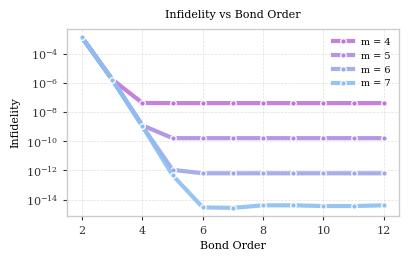

In [9]:

# Define compatible pastel colormap (slightly different from first plot)
pastel_colors_v2 = [
    (0.75, 0.45, 0.85),   # pastel purple
    (0.55, 0.75, 0.95),   # pastel sky blue
]

# Create colormap for the 4 lines (m = 4, 5, 6, 7)
cmap = plt_colors.LinearSegmentedColormap.from_list("compatible_pastel", pastel_colors_v2, N=4)
colors = [cmap(i) for i in np.linspace(0, 1, 4)]

# Create figure with same size as your first plot
fig, ax = plt.subplots(figsize=(4, 2.5))  # Half width since it's a single plot

plt.yscale('log')
# Plot with pastel gradient colors and improved styling
for idx, m in enumerate(range(4, 8)):
    # Replace this line with your actual function call:
    # y_values = [get_infidelity(m, trunc) for trunc in range(2, 13)]
    
    # Sample data for demonstration - replace with your actual data
    x_values = list(range(2, 13))
    y_values = [get_infidelity(m, trunc) for trunc in range(2, 13)]
    
    plt.plot(x_values, y_values, 
             color=colors[idx], 
             linewidth=3, 
             alpha=0.9,
             label=f'm = {m}',
             marker='o',
             markersize=4,
             markerfacecolor=colors[idx],
             markeredgecolor='white',
             markeredgewidth=1)

# Styling to match your first plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
plt.tick_params(axis='both', which='major', labelsize=8, length=3, width=0.8, colors='#333333')

# Set spine colors to match
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')
    spine.set_linewidth(1)

# Labels and title
plt.xlabel("Bond Order", fontsize=8, labelpad=4)
plt.ylabel("Infidelity", fontsize=8, labelpad=4)
plt.title("Infidelity vs Bond Order", fontsize=8, pad=8)

# Legend with same styling as first plot
plt.legend(loc="best", fontsize=7, frameon=False)

# Adjust layout to match your first plot's spacing
plt.subplots_adjust(
    left=0.12,
    bottom=0.15,
    right=0.95,
    top=0.90
)

plt.savefig("../Finalized Figures/trunc_plot.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()


In [10]:
l = 2**m
x_coarse = np.linspace(0,1,l+1)
poly_list = get_polys(x_coarse,f_shift_scale,df_shift_scale)  

M_list = []
for i,p in enumerate(poly_list):
    reg = [i//2**_%2 for _ in range(m)[::-1]]
    M = MPS_poly(n-1,p,reg)
    M_list.append(M)

M_full = (reduce(lambda a,b: MPS_sum(a,b),M_list))

M_trunc = trunc_mps(M_full, 6)

In [11]:
opt_layers, results, _ = optimize_mps_circuit(M_trunc, 6)

Optimization for Layer  1
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -6.6763536552710123e+00    4.55599667e-02    
   2         -6.6763536552710123e+00    4.55599667e-02    
Terminated - min step_size reached after 2 iterations, 0.06 seconds.

Optimization for Layer  2
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -8.4120655135891766e+00    6.44256283e+00    
   2         -8.4197938022536736e+00    1.25727618e+01    
   3         -8.4409160778005337e+00    1.90590863e+01    
   4         -8.5012436805844551e+00    1.53263925e+01    
   5         -8.5179838765478149e+00    1.81037072e+01    
   6         -8.5424399045647821e+00    8.26104844e+00    
   7         -8.5439438764421283e+00    5.48752248e+00    
   8         -8.5462422867573906e+00    4.76186098e+00    
   9         -8.54843054

In [12]:
layers = []
while len(layers) < 6:
    layers = get_next_layer(layers, M_trunc)

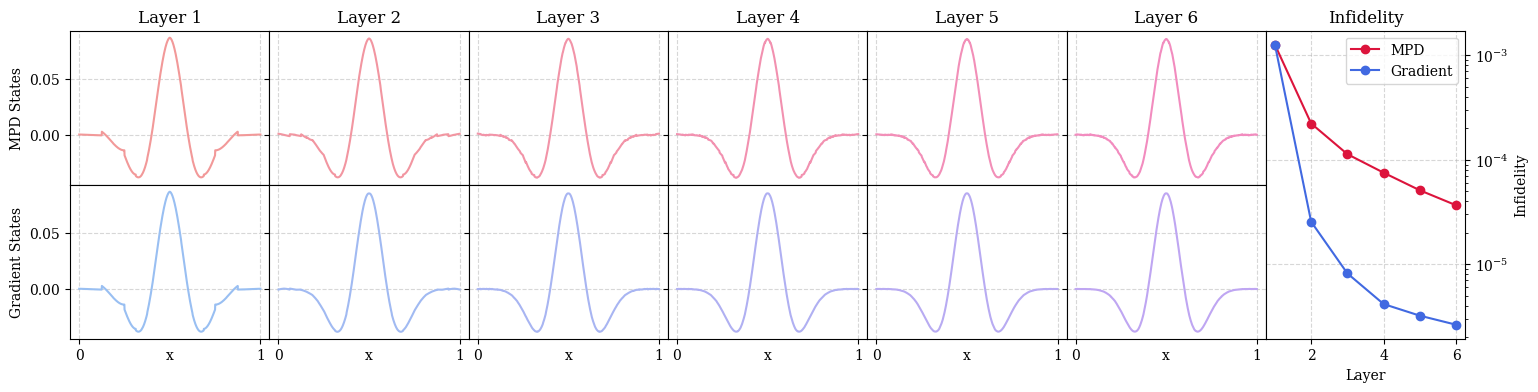

In [13]:
# -------------------------
# Number of layers
# -------------------------
num_layers = 6   

# Define warm pastel gradient (top row)
warm_pastel = [
    (0.95, 0.60, 0.60),   # pastel red
    (0.95, 0.55, 0.75),   # pastel pink
]
warm_cmap = plt_colors.LinearSegmentedColormap.from_list("warm_pastel", warm_pastel, N=num_layers)
warm_colors = [warm_cmap(i) for i in np.linspace(0, 1, num_layers)]

# Define cool pastel gradient (bottom row)
cool_pastel = [
    (0.60, 0.75, 0.95),   # pastel blue
    (0.75, 0.65, 0.95),   # pastel lavender
]
cool_cmap = plt_colors.LinearSegmentedColormap.from_list("cool_pastel", cool_pastel, N=num_layers)
cool_colors = [cool_cmap(i) for i in np.linspace(0, 1, num_layers)]

# -------------------------
# Figure setup
# -------------------------
fig = plt.figure(figsize=(3*num_layers, 4))
gs = gridspec.GridSpec(2, num_layers+1, figure=fig)  # +1 for infidelity axis

# Subplot grid
ax = np.empty((2, num_layers+1), dtype=object)
for row in range(2):
    for col in range(num_layers):
        ax[row, col] = fig.add_subplot(gs[row, col])
ax_inf = fig.add_subplot(gs[:, num_layers])
ax[:, num_layers] = ax_inf

# -------------------------
# Data & plots
# -------------------------
exact_state = f(x) / np.linalg.norm(f(x))
mpd_infid, grad_infid = [], []

# First num_layers columns: state plots
for i in range(num_layers):
    # Top row: MPD (warm pastel)
    state = zero_mps(n-1)
    for l in layers[num_layers-1 - i:]:
        state = entangle_layer(state, l)
        
    state = get_state(state)
    state = np.concatenate([state, state[::-1]])/np.sqrt(2)
    ax[0, i].plot(x, state, color=warm_colors[i])
    mpd_infid.append(1 - np.dot(exact_state, state)**2)

    # Bottom row: Gradient (cool pastel)
    state = zero_mps(n-1)
    temp_layers = [results[i].point[j*(n-1):(j+1)*(n-1)] for j in range(i+1)]
    for l in temp_layers:
        state = entangle_layer(state, l)
    state = get_state(state)
    state = np.concatenate([state, state[::-1]])/np.sqrt(2)
    ax[1, i].plot(x, state, color=cool_colors[i])
    grad_infid.append(1 - np.dot(exact_state, state)**2)

# -------------------------
# Infidelity plot
# -------------------------
ax_inf.set_yscale('log')
ax_inf.plot(range(1, num_layers+1), mpd_infid, '-o', label='MPD', color='crimson')
ax_inf.plot(range(1, num_layers+1), grad_infid, '-o', label='Gradient', color='royalblue')
ax_inf.set_xlabel('Layer')
ax_inf.set_ylabel('Infidelity')
ax_inf.legend()
ax_inf.set_title('Infidelity')

# -------------------------
# Formatting
# -------------------------
for row in range(2):
    all_ylims = [ax[row, col].get_ylim() for col in range(num_layers)]
    ymin = min(lim[0] for lim in all_ylims)
    ymax = max(lim[1] for lim in all_ylims)
    for col in range(num_layers):
        ax[row, col].set_ylim(ymin, ymax)

        if col == 0:
            ax[row, col].tick_params(labelleft=True)
        else:
            ax[row, col].tick_params(labelleft=False)

        ax[row, col].grid(True, linestyle="--", alpha=0.5)

        # x-ticks
        ax[row, col].set_xticks([0, 1])
        if row == 1:
            ax[row, col].set_xticklabels(["0", "1"])
            ax[row, col].set_xlabel('x', labelpad=-10)
        else:
            ax[row, col].set_xticklabels([])

# Titles and labels
for i in range(num_layers):
    ax[0, i].set_title(f'Layer {i+1}')
ax[0, 0].set_ylabel('MPD States')
ax[1, 0].set_ylabel('Gradient States')

# Infidelity axis formatting
ax_inf.yaxis.tick_right()
ax_inf.yaxis.set_label_position("right")
ax_inf.grid(True, linestyle="--", alpha=0.5)

plt.subplots_adjust(wspace=0.0, hspace=0)
plt.savefig("../Finalized Figures/layer_plot.pdf", dpi=300)
plt.show()


In [14]:
np.save('mps.npy', np.array(opt_layers, dtype=object), allow_pickle=True)
np.save('results.npy', np.array(results, dtype=object), allow_pickle=True)